# Optimizing Edge Detection with NumPy

This notebook demonstrates how to vectorize the Sobel operator and sliding window operations for edge detection. By using NumPy slicing and reshaping, we avoid Python-level loops and speed up the processing while using only NumPy and PIL.

In [1]:
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt  # For visualizing the edge map (optional)

## Sobel Operator 
This function computes the gradient magnitude of a grayscale image using a vectorized Sobel operator. In image processing, the Sobel operator estimates the first derivative (gradient) of the image's intensity in both the horizontal and vertical directions. The gradient magnitude, which highlights edges, is calculated as:

$$
\text{grad\_magnitude} = \sqrt{G_x^2 + G_y^2}
$$

### Sobel Kernels

The Sobel operator uses two 3×3 kernels:

- **Horizontal Kernel ($K_x$):**

  $$
  K_x =
  \begin{bmatrix}
  -1 & 0 & 1 \\
  -2 & 0 & 2 \\
  -1 & 0 & 1
  \end{bmatrix}
  $$

- **Vertical Kernel ($K_y$):**

  $$
  K_y =
  \begin{bmatrix}
  -1 & -2 & -1 \\
   0 &  0 &  0 \\
   1 &  2 &  1
  \end{bmatrix}
  $$

In [2]:
def sobel_gradients(gray_image):
    """
    Compute the gradient magnitude using a vectorized Sobel operator.
    """
    # Sobel kernels
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]], dtype=np.float32)
    
    padded = np.pad(gray_image, ((1, 1), (1, 1)), mode='edge')
    
    # Compute Gx and Gy using slicing
    Gx = (Kx[0,0]*padded[:-2, :-2] + Kx[0,1]*padded[:-2, 1:-1] + Kx[0,2]*padded[:-2, 2:] +
          Kx[1,0]*padded[1:-1, :-2] + Kx[1,1]*padded[1:-1, 1:-1] + Kx[1,2]*padded[1:-1, 2:] +
          Kx[2,0]*padded[2:, :-2] + Kx[2,1]*padded[2:, 1:-1] + Kx[2,2]*padded[2:, 2:])
    
    Gy = (Ky[0,0]*padded[:-2, :-2] + Ky[0,1]*padded[:-2, 1:-1] + Ky[0,2]*padded[:-2, 2:] +
          Ky[1,0]*padded[1:-1, :-2] + Ky[1,1]*padded[1:-1, 1:-1] + Ky[1,2]*padded[1:-1, 2:] +
          Ky[2,0]*padded[2:, :-2] + Ky[2,1]*padded[2:, 1:-1] + Ky[2,2]*padded[2:, 2:])
    
    grad_magnitude = np.sqrt(Gx**2 + Gy**2)
    return grad_magnitude

1. **Image Padding:**
   - The input image is padded using the 'edge' mode. This means the border values of the image are replicated, ensuring that the convolution operation (applying the kernels) can be performed on every pixel without running into boundary issues.

2. **Computing the Gradients:**
   - **Horizontal Gradient ($G_x$):**  
     The function computes $G_x$ by applying the kernel $K_x$ over the image using NumPy slicing:
     $$
     G_x = \sum_{i=0}^{2} \sum_{j=0}^{2} K_x[i,j] \cdot I_{(x+i-1,\, y+j-1)}
     $$
     where \( I \) is the padded image.
     
   - **Vertical Gradient ($G_y$):**  
     Similarly, $G_y$ is computed using the kernel $K_y$:
     $$
     G_y = \sum_{i=0}^{2} \sum_{j=0}^{2} K_y[i,j] \cdot I_{(x+i-1,\, y+j-1)}
     $$

3. **Calculating Gradient Magnitude:**
   - The gradient magnitude for each pixel is computed using the Euclidean norm:
     $$
     \text{grad\_magnitude} = \sqrt{G_x^2 + G_y^2}
     $$

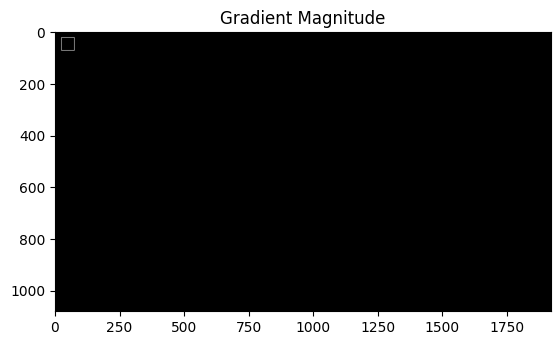

In [3]:
# Create a dummy image (or load an image using Image.open(path))
dummy = np.zeros((1080, 1920), dtype=np.float32)
dummy[25:75, 25:75] = 255
    
grad = sobel_gradients(dummy)
plt.imshow(grad, cmap='gray')
plt.title('Gradient Magnitude')
plt.show()

| **Aspect**              | **Pros**                                                                                                              | **Cons**                                                                                                                                      |
|-------------------------|-----------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------|
| **Performance**         | - Uses vectorized NumPy operations for fast computation, ideal for processing large images efficiently.              | - Relies on CPU-based computation; may not be optimal for real-time processing on very large datasets compared to GPU-accelerated methods.    |
| **Code Readability**    | - Concise and modular implementation clearly demonstrates the Sobel operator’s logic.                                 | - Advanced slicing and broadcasting may be challenging for beginners to understand without prior experience in vectorized operations.         |
| **Edge Handling**       | - Employs 'edge' padding to mitigate boundary issues, ensuring the kernels are applied uniformly across the image.      | - The 'edge' padding approach might not be suitable for all image types or edge cases, and may require adjustment depending on application.  |
| **Flexibility**         | - Easy to modify for different kernels or incorporate into larger image processing pipelines.                         | - Limited to fixed kernel sizes (3×3) in the current implementation; adapting to variable kernel sizes requires additional modifications.   |
| **Dependency & Integration** | - Leverages widely-used libraries (NumPy) making it easy to integrate with other scientific computing and image processing libraries. | - Dependent on external libraries (NumPy, and PIL ), which adds overhead and complexity. |


## **Vectorized Sliding Window for Edge Blobs**

## Purpose
- **Edge Concentration Measurement:**  
  The function `max_blob_fraction` determines the maximum fraction of edge pixels (blob) in any fixed-size window of an edge map. This helps assess how densely clustered the edge information is in different regions of the image.

In [4]:
def max_blob_fraction(edge_map, window_size):
    H, W = edge_map.shape
    # Only consider regions that fully fit the window
    H_new = H - (H % window_size)
    W_new = W - (W % window_size)
    trimmed = edge_map[:H_new, :W_new]
    
    # Reshape so that each block is a separate array
    blocks = trimmed.reshape(H_new // window_size, window_size,
                               W_new // window_size, window_size)
    
    # Sum over the pixels in each block
    block_sums = blocks.sum(axis=(1, 3))
    max_blob = block_sums.max()
    
    return max_blob / (window_size * window_size)

## How the Code Works

### 1. Trimming the Edge Map
- **Input:**  
  A binary edge map (e.g., values 0 for non-edge, 1 for edge) and a specified `window_size`.
- **Operation:**  
  The image dimensions are adjusted (trimmed) so they are multiples of the `window_size`. This ensures that every window used for analysis is a complete block with no partial windows.

### 2. Reshaping into Blocks
- **Process:**  
  The trimmed edge map is reshaped into a 4D array where:
  - The first and third dimensions correspond to the number of windows (blocks) in the vertical and horizontal directions.
  - The second and fourth dimensions represent the pixels within each block (of size `window_size x window_size`).

### 3. Summing Edge Values in Each Block
- **Calculation:**  
  For each block, the function sums the pixel values.  
  - Since the edge map is binary, this sum tells you how many edge pixels are present in that block.

### 4. Calculating the Maximum Blob Fraction
- **Finding the Maximum:**  
  The maximum sum among all the blocks (`max_blob`) is found.
- **Normalization:**  
  This maximum sum is divided by the total number of pixels in a block (`window_size * window_size`) to get a fraction.
- **Interpretation:**  
  The fraction represents the highest density (or concentration) of edges found in any block of the image.


In [5]:
# Quick test on a binary edge map
dummy_edge = np.zeros((1920, 1080), dtype=np.uint8)
dummy_edge[30:50, 30:50] = 1
print('Max blob fraction:', max_blob_fraction(dummy_edge, window_size=20))

Max blob fraction: 0.25


### Example: Why the Max Blob Fraction is 0.25

- **Dummy Edge Map Creation:**  
  A test edge map of size (1920, 1080) is initialized with zeros. A white square (with value 1) is added from rows 30 to 50 and columns 30 to 50.
  
- **Window Size:**  
  The chosen window size is 20.
  
- **White Square Distribution:**  
  - The white square spans 20 rows and 20 columns.  
  - However, because the image is divided into 20×20 blocks, the white square straddles across four adjacent blocks.
  - Each of these four blocks only contains a 10×10 region of the white square (i.e., 100 edge pixels per block).

- **Fraction Calculation:**  
  - Each block contains a total of 20×20 = 400 pixels.
  - The block with the highest number of edge pixels has 100 ones.
  - Thus, the maximum blob fraction is computed as:  
$$
\text{Max Blob Fraction} = \frac{\text{Edge Pixels}}{\text{Total Pixels}} = \frac{100}{400} = 0.25
$$



## Combined Function: Compute Edge Confidence

The function `compute_edge_confidence` puts everything together. It converts a PIL image to grayscale, computes the Sobel gradient magnitude, creates a binary edge map, and then computes two metrics (global edge fraction and maximum blob fraction) to yield a final confidence score.

Edge confidence: 0.7526849440586421


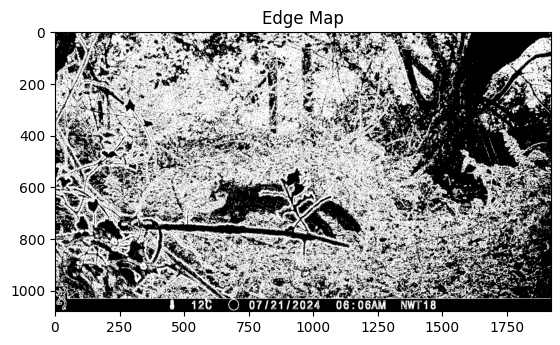

In [6]:

def compute_edge_confidence(pil_image, edge_threshold=50, window_size=20):
    """
    Computes an edge-based confidence score indicating the likelihood of an animal presence.
    
    Parameters:
      - pil_image: A PIL Image object.
      - edge_threshold: Threshold on gradient magnitude for edge detection.
      - window_size: Size of the sliding window to capture local edge blobs.
    
    Returns:
      - confidence: A value between 0 and 1.
      - edge_map: The binary edge image (for optional debugging/visualization).
    """
    # Convert the PIL image to grayscale (as a NumPy array)
    gray_array = np.array(pil_image.convert('L'), dtype=np.float32)
    
    # Compute the gradient magnitude
    grad_mag = sobel_gradients(gray_array)
    
    # Create a binary edge map: pixels above edge_threshold are 1
    edge_map = (grad_mag > edge_threshold).astype(np.uint8)
    
    # Global edge fraction: total edge pixels divided by total pixels
    edge_fraction = np.sum(edge_map) / edge_map.size
    
    # Compute maximum blob fraction using vectorized sliding window
    blob_fraction = max_blob_fraction(edge_map, window_size)
    
    # Combine the two metrics into a single confidence value
    confidence = (edge_fraction + blob_fraction) / 2.0
    return confidence, edge_map

# Example usage: load an image and compute its edge confidence

image = Image.open(r'C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\ds_researchATU\IMG_0197.JPG')
confidence, edge_map = compute_edge_confidence(image)
print('Edge confidence:', confidence)
plt.imshow(edge_map, cmap='gray')
plt.title('Edge Map')
plt.show()
